In [1]:
import torch
import torch.nn as nn

import math
import torch.autograd as autograd

from torch.utils.tensorboard import SummaryWriter


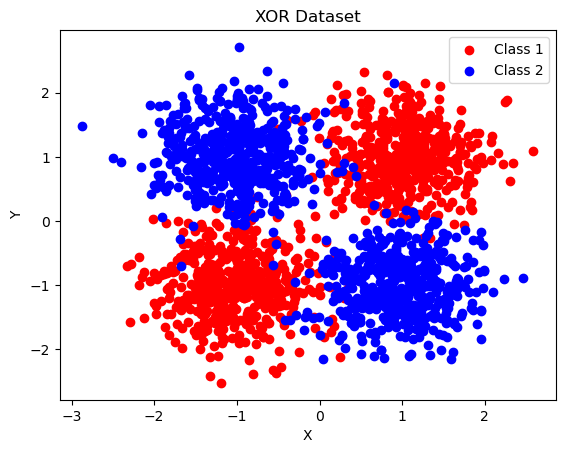

In [2]:

autograd.set_detect_anomaly(True)

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Generate class 1 points (top left and bottom right)
class1 = np.random.normal(loc=[-1, -1], scale=0.5, size=(500, 2))
class1 = np.concatenate((class1, np.random.normal(loc=[1, 1], scale=0.5, size=(500, 2))))

# Generate class 2 points (top right and bottom left)
class2 = np.random.normal(loc=[1, -1], scale=0.5, size=(500, 2))
class2 = np.concatenate((class2, np.random.normal(loc=[-1, 1], scale=0.5, size=(500, 2))))


# Combine class 1 and class 2 points
X = np.concatenate((class1, class2))
y = np.concatenate((np.full(1000, 0), np.full(1000, 1)))

# Plot the dataset
plt.scatter(class1[:, 0], class1[:, 1], c='red', label='Class 1')
plt.scatter(class2[:, 0], class2[:, 1], c='blue', label='Class 2')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XOR Dataset')
plt.legend()
plt.savefig('xor.png')
plt.show()



In [3]:
# convert the numpy arrays to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
# shuffle the data
shuffle_idx = torch.randperm(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]
y = y.unsqueeze(dim=1)
y 

tensor([[0.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [4]:
writer = SummaryWriter(log_dir="runs/quasipoly")

In [5]:
X

tensor([[-0.3675, -0.8943],
        [-0.9466,  0.5441],
        [ 1.2754, -0.7023],
        ...,
        [ 1.7939,  0.6784],
        [-0.9742, -0.5664],
        [-1.1085, -0.7773]])

In [6]:

class QuasiPolySynapse(nn.Module):
    def __init__(self):
        super().__init__() 
        self.main = nn.ParameterList([torch.randn(1),torch.tensor([1.],requires_grad=False)])
        # self.main = nn.ParameterList([torch.randn(1)])
        self.terms = nn.ParameterList()

        
    def forward(self, x):
        if  len(self.terms) < math.floor(self.main[1]) - 1:
            self.add_term()
        y = self.main[0] * x ** self.main[1]
        for idx,coeff in enumerate(self.terms):
             y = y + coeff * x**(idx+1)
        return y

    def add_term(self):
        print("Adding term")
        # Add new term, init coeff to 1. non-trainable exponent to floor of main exponent
        self.terms.append(nn.Parameter(torch.tensor([1.])))

    def __str__(self):
        s = ""
        s += f"Main: {self.main[0]}x^{self.main[1]} + "
        for idx,term in enumerate(self.terms):
            s += f"{term}x^{idx+1} + "
        return s[:-3]



class QuasiPolyLayer(nn.Module):
  def __init__(self, in_features, out_features, product=False):
    super().__init__()
    self.out_features = out_features
    self.in_features = in_features
    # a 2d module list of quasipoly synapses sizes in_features x out_features
    self.synapses = nn.ModuleList([nn.ModuleList([QuasiPolySynapse() for _ in range(self.in_features)]) for _ in range(self.out_features)])
    self.bias = nn.Parameter(torch.randn(out_features))
    self.product = product
  
  def forward(self, x): # x is a batch of inputs

    y = torch.zeros(x.shape[0], self.out_features, dtype=torch.float32)
    
    # apply synapses to inputs
    for i in range(self.out_features):
        if self.product:
            y[:, i] = 1
        else:
            y[:, i] = 0
    
        for j in range(self.in_features):
            if self.product:
                y[:, i] = y[:, i] * self.synapses[i][j](x[:, j])
            else:
                y[:, i] = y[:, i] + self.synapses[i][j](x[:, j])

    # add bias
    y = y + self.bias

    return y
  


class AddEpsilon(nn.Module):
    def __init__(self, epsilon=1e-10): # 1e-10 is smallest possible float in pytorch
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x):
        return x + self.epsilon
    


In [10]:
import torch.autograd.profiler as profiler

# Define the training loop function
def train_model(model, X, y, num_epochs, batch_size, calulate_backward_time=False):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    writer.add_graph(model, X)
    num_samples = X.shape[0]

    total_backward_time = 0

    for epoch in range(num_epochs):
        for i in range(0, num_samples, batch_size):
            # Get the batch
            batch_X = X[i:i+batch_size]
            batch_y = y[i:i+batch_size]

            # Forward pass
            outputs = model(batch_X)

            loss = criterion(outputs, batch_y)

            # Backward and optimize
            optimizer.zero_grad()
            if calulate_backward_time:
                with profiler.profile(use_cuda=False) as prof:
                    loss.backward()
            else:
                loss.backward()

            optimizer.step()

            # Calculate accuracy
            preds = (outputs > 0.5).float()
            accuracy = (preds == batch_y).float().mean()

            # Print loss and accuracy
            if calulate_backward_time:
                total_backward_time += prof.total_average().self_cpu_time_total
        print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}, cumulative backward time: {total_backward_time}")
            # print(f"Total time spent during backward pass: {prof.total_average().self_cpu_time_total}")
        



def plot_decision_boundary(model, X, y, save_file_name=""):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    grid = np.c_[xx.ravel(), yy.ravel()]

    with torch.no_grad():
        model.eval()
        output = model(torch.from_numpy(grid).float())
        preds = (output > 0.5).float()
        

    Z = preds.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y[:], cmap=plt.cm.Spectral)

    # save to file
    if len(save_file_name) > 0:
        plt.savefig(save_file_name,bbox_inches='tight')

    plt.show()





In [11]:
# Train the model
EPOCH_COUNT = 300
BATCH_SIZE = 100

### Simplest Linear Model To Calculate XOR

In [14]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 1), 
    nn.Sigmoid()
)

train_model(model, X, y, num_epochs=20, batch_size=BATCH_SIZE)

Epoch 1, Loss: 0.643390953540802, Accuracy: 0.6899999976158142, cumulative backward time: 0
Epoch 2, Loss: 0.566742479801178, Accuracy: 0.8100000023841858, cumulative backward time: 0
Epoch 3, Loss: 0.47092971205711365, Accuracy: 0.9200000166893005, cumulative backward time: 0
Epoch 4, Loss: 0.3721909821033478, Accuracy: 0.949999988079071, cumulative backward time: 0
Epoch 5, Loss: 0.27979081869125366, Accuracy: 0.9399999976158142, cumulative backward time: 0
Epoch 6, Loss: 0.20910796523094177, Accuracy: 0.9300000071525574, cumulative backward time: 0
Epoch 7, Loss: 0.16878773272037506, Accuracy: 0.9300000071525574, cumulative backward time: 0
Epoch 8, Loss: 0.14758576452732086, Accuracy: 0.9300000071525574, cumulative backward time: 0
Epoch 9, Loss: 0.13582175970077515, Accuracy: 0.9300000071525574, cumulative backward time: 0
Epoch 10, Loss: 0.12880663573741913, Accuracy: 0.9300000071525574, cumulative backward time: 0
Epoch 11, Loss: 0.12440982460975647, Accuracy: 0.9300000071525574

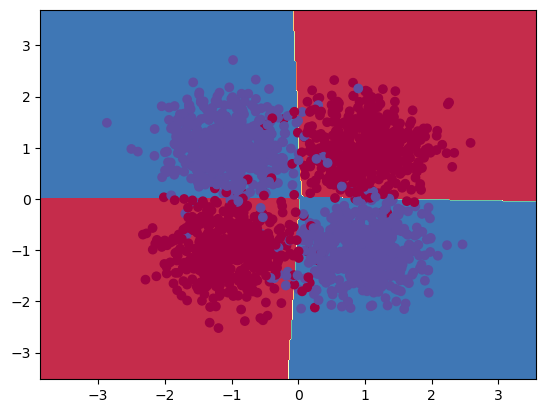

In [15]:
plot_decision_boundary(model, X, y,save_file_name="xor_decision_boundary_linear.png")

In [135]:
with torch.autograd.profiler.profile(use_cuda=False) as prof:
    output = model(X)

print(prof.key_averages().table(sort_by="self_cpu_time_total"))

----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
               aten::t        56.45%       1.322ms        57.17%       1.339ms     669.500us             2  
           aten::addmm        26.64%     624.000us        27.97%     655.000us     327.500us             2  
            aten::relu         7.98%     187.000us         8.50%     199.000us     199.000us             1  
         aten::sigmoid         5.85%     137.000us         5.85%     137.000us     137.000us             1  
           aten::copy_         1.02%      24.000us         1.02%      24.000us      12.000us             2  
          aten::linear         0.51%      12.000us        85.65%       2.006ms       1.003ms             2  
       aten::clamp_

STAGE:2024-03-08 19:11:03 9002:9002 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-08 19:11:03 9002:9002 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-08 19:11:03 9002:9002 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


### Simplest QuasiPolynomial Model To Calculate XOR mixed with linear

In [16]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),# using relu to prevent negative values
    AddEpsilon(),
    QuasiPolyLayer(4,1),
    nn.Sigmoid()
)

train_model(model, X, y, num_epochs=20, batch_size=BATCH_SIZE)

/tmp/ipykernel_93586/3500531415.py:10: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if  len(self.terms) < math.floor(self.main[1]) - 1:


Epoch 1, Loss: 0.6464826464653015, Accuracy: 0.6800000071525574, cumulative backward time: 0
Epoch 2, Loss: 0.4855303168296814, Accuracy: 0.7400000095367432, cumulative backward time: 0
Epoch 3, Loss: 0.33983245491981506, Accuracy: 0.9100000262260437, cumulative backward time: 0
Epoch 4, Loss: 0.26048561930656433, Accuracy: 0.9300000071525574, cumulative backward time: 0
Adding term
Epoch 5, Loss: 0.22484593093395233, Accuracy: 0.9399999976158142, cumulative backward time: 0
Epoch 6, Loss: 0.20550638437271118, Accuracy: 0.9399999976158142, cumulative backward time: 0
Epoch 7, Loss: 0.20321041345596313, Accuracy: 0.9399999976158142, cumulative backward time: 0
Epoch 8, Loss: 0.19938701391220093, Accuracy: 0.9399999976158142, cumulative backward time: 0
Epoch 9, Loss: 0.19542831182479858, Accuracy: 0.9300000071525574, cumulative backward time: 0
Epoch 10, Loss: 0.192355215549469, Accuracy: 0.9300000071525574, cumulative backward time: 0
Epoch 11, Loss: 0.18846353888511658, Accuracy: 0.93

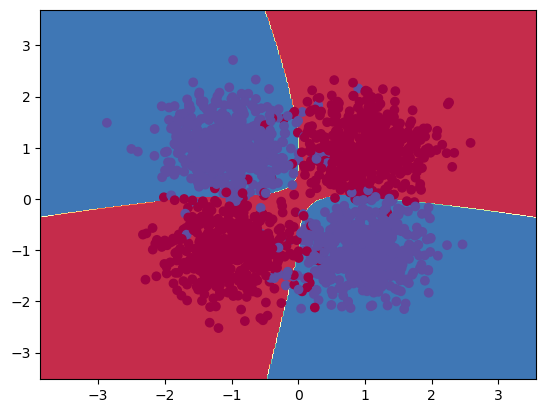

In [180]:
plot_decision_boundary(model, X, y,save_file_name="xor_decision_boundary_quasipoly.png")

In [142]:
with torch.autograd.profiler.profile(use_cuda=False) as prof:
    output = model(X)

print(prof.key_averages().table(sort_by="self_cpu_time_total"))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::copy_        15.19%       1.364ms        15.19%       1.364ms     170.500us             8  
                    aten::pow        13.78%       1.237ms        13.83%       1.242ms     248.400us             5  
                    aten::mul        13.29%       1.193ms        13.29%       1.193ms     238.600us             5  
                  aten::slice        12.76%       1.146ms        12.78%       1.148ms      88.308us            13  
                 aten::select        12.58%       1.130ms        12.62%       1.133ms      87.154us            13  
                      aten::t        11.40%       1.024ms        11.54% 

STAGE:2024-03-08 19:13:01 9002:9002 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-08 19:13:01 9002:9002 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-08 19:13:01 9002:9002 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [19]:
# Scale the data between 0 and 1 using min-max scaling
X = (X - X.min()) / (X.max() - X.min())

#### All-Quasipolynomial

In [27]:
model = nn.Sequential(
    QuasiPolyLayer(2, 4),
    nn.ReLU(),
    AddEpsilon(),
    QuasiPolyLayer(4, 1),
    nn.Sigmoid()
)

train_model(model, X, y, num_epochs=50, batch_size=BATCH_SIZE)

/tmp/ipykernel_93586/3500531415.py:10: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if  len(self.terms) < math.floor(self.main[1]) - 1:


Epoch 1, Loss: 0.654704749584198, Accuracy: 0.800000011920929, cumulative backward time: 0
Epoch 2, Loss: 0.6418209075927734, Accuracy: 0.8399999737739563, cumulative backward time: 0
Epoch 3, Loss: 0.6214128732681274, Accuracy: 0.8500000238418579, cumulative backward time: 0
Epoch 4, Loss: 0.5966113805770874, Accuracy: 0.8199999928474426, cumulative backward time: 0
Epoch 5, Loss: 0.5570583939552307, Accuracy: 0.8899999856948853, cumulative backward time: 0
Epoch 6, Loss: 0.5156412720680237, Accuracy: 0.8799999952316284, cumulative backward time: 0
Epoch 7, Loss: 0.4538062810897827, Accuracy: 0.9100000262260437, cumulative backward time: 0
Epoch 8, Loss: 0.4235492944717407, Accuracy: 0.8899999856948853, cumulative backward time: 0
Epoch 9, Loss: 0.4399346113204956, Accuracy: 0.8600000143051147, cumulative backward time: 0
Epoch 10, Loss: 0.38237816095352173, Accuracy: 0.8899999856948853, cumulative backward time: 0
Epoch 11, Loss: 0.362913578748703, Accuracy: 0.8799999952316284, cumul

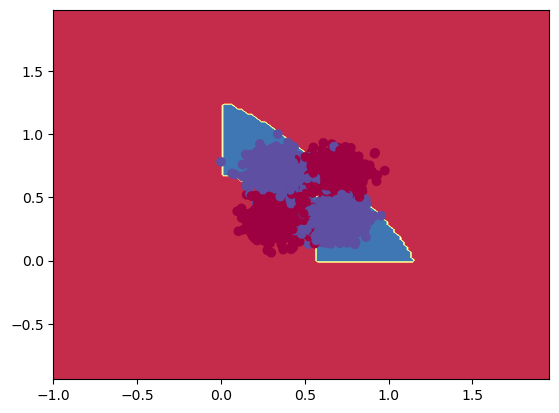

In [28]:
plot_decision_boundary(model, X, y,save_file_name="xor_decision_boundary_quasipoly_scaled.png")

In [223]:
with torch.autograd.profiler.profile(use_cuda=False) as prof:
    output = model(X)

print(prof.key_averages().table(sort_by="self_cpu_time_total"))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::copy_        20.74%       4.376ms        20.74%       4.376ms     243.111us            18  
                    aten::pow        17.43%       3.679ms        17.43%       3.679ms     306.583us            12  
                  aten::slice        15.41%       3.252ms        15.51%       3.273ms      79.829us            41  
                 aten::select        15.15%       3.197ms        15.19%       3.206ms      78.195us            41  
                    aten::mul        13.93%       2.940ms        13.93%       2.940ms     245.000us            12  
                    aten::add        10.06%       2.124ms        10.13% 

STAGE:2024-03-08 21:22:01 9002:9002 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-08 21:22:01 9002:9002 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-08 21:22:01 9002:9002 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


#### Product synapses: under construction

In [32]:
model = nn.Sequential(
    QuasiPolyLayer(2, 6, product=True),
    nn.ReLU(),
    AddEpsilon(),
    QuasiPolyLayer(6, 2, product=True),
    nn.Softmax(dim=1)
)

train_model(model, X, y, num_epochs=100, batch_size=BATCH_SIZE)

/tmp/ipykernel_60864/3500531415.py:10: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if  len(self.terms) < math.floor(self.main[1]) - 1:
/home/parsa/anaconda3/envs/mlenv/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/parsa/anaconda3/envs/mlenv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/parsa/anaconda3/envs/mlenv/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/home/parsa/anaconda3/envs/mlenv/lib/python3.11/s

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [100]], which is output 0 of AsStridedBackward0, is at version 14; expected version 13 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
class InputMultiplyx1x2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x[:, 0] * x[:, 1]
    
model = InputMultiplyx1x2()

train_model(model, X, y, 100, BATCH_SIZE)

ValueError: optimizer got an empty parameter list

https://pytorch.org/docs/main/torch.compiler_ir.html